# Exploring Features for Differentiating Fraudulent and Nonfraudulent Transactions

Wyatt V. Sharber

14 July 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir("../../src/")
import fraudfuncs as fraud
os.chdir("../notebooks/final/")
data = pd.read_csv("../../data/raw/sa_exercise_file.csv")
import warnings 
warnings.filterwarnings('ignore')

## Overview

In order to suggest optimal use cases for identifying fraudulent transactions for the potential customer, I performed exploratory data analyses on the provided data, focusing on transactions from three countries: China (CN), Malaysia (MY), and Hong Kong (HK). 

I selected three features for each country that represent promising candidates for building or improving fraud detection systems, either machine learning or rule based.

## Summary of Entire Dataset

The dataset consists of 300,000 transaction records. These include the country of origin, 5 data features (3 continuous numerical, 2 categorical), and a label for identifying the transaction as fraudulent or not. 

The fraud rate for the entire dataset is about 1.1%, but varies greatly from country to country.

In [5]:
#Fraud rate for entire dataset
total_fraud_rate = (len(data[data['isfraud'] == 1])/len(data))*100
total_fraud_rate

1.127

The countries with the 5 highest fraud rates are listed below:

1. Tonga
2. Grenada
3. Algeria
4. Aruba
5. Andorra

In [7]:
#Calculate fraud rates for each country
fraud_rates = pd.DataFrame(columns = ['Country', 'Fraud Rate', 'Number of Transactions'])
for each in data['input country code'].unique():
    fraud_rates = fraud_rates.append({'Country': each, 
                                      'Fraud Rate': (len(data[(data['isfraud'] == 1) & (data['input country code'] == each)])/len(data[data['input country code'] == each]))*100,
                                      'Number of Transactions': len(data[data['input country code'] == each])},
                                     ignore_index = True)   

In [8]:
fraud_rates.sort_values(by = 'Fraud Rate', ascending = False)[0:5]

,Country,Fraud Rate,Number of Transactions
204,to,100.000000,2
198,gd,100.000000,1
74,dz,64.361702,188
110,aw,58.646617,133
98,ad,50.704225,142


There transactions from 215 different countries in the data, but over 83% of the transactions originate from only 10 countries, mostly in East Asia. 

In [11]:
#Top ten countries by number of data points
data['input country code'].value_counts()[0:10]

my    95531
cn    61705
tw    33856
sg    22606
au    10219
hk     8498
kr     7757
th     6402
jp     5974
gb     4110
Name: input country code, dtype: int64

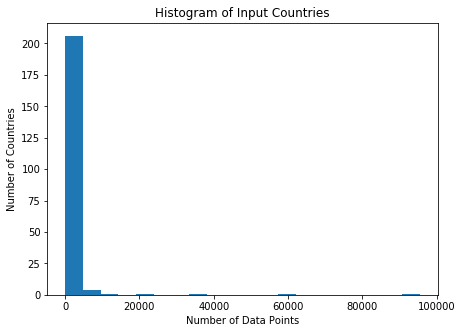

In [14]:
#Small number of countries represent most of the data
fig, ax = plt.subplots(1,1, figsize = (7, 5))
data['input country code'].value_counts().hist(grid = False, bins = 20, ax = ax)
ax.set_title("Histogram of Input Countries")
ax.set_xlabel("Number of Data Points")
ax.set_ylabel("Number of Countries");

### Missing Data

There is significant amounts of missing data in some of the features. I have attempted to deal with them appropriately depending on the amount of missing data per feature and the potential effect of the presence of missing data on the fraud outcome. 

- For categorical variables, I added another category for missing data
- For continuous variables, I represent the missing data in a separate bin after binning the continuous data for plotting in histograms

In [15]:
#Check for missing data
data.isna().sum()

input country code              0
Primary Phone to Name       11299
Email to Name                1198
Email First Seen Days        1208
IP Distance From Address    72631
Transaction Risk Score          3
isfraud                         0
dtype: int64

## Criteria for Feature Selection

I performed preliminary data analyses to choose which features to highlight for the 3 countries of interest. The two most important criteria I considered were:
1. Calculated feature correlation to fraud label
2. Ability to visually identify a "breaking point" in differentiating fraudulent vs. nonfraudulent transactions

In addition, I considered each feature for the country of interest in comparison to the entire dataset, which occasionally showed that some features have higher or lower use in the given country. For example, the 'Primary Phone to Name' feature shows that relatively few transactions from China are able to find a name associated with the given phone number. This may indicate that phones are used less often as an identifying feature in China compared to other countries.

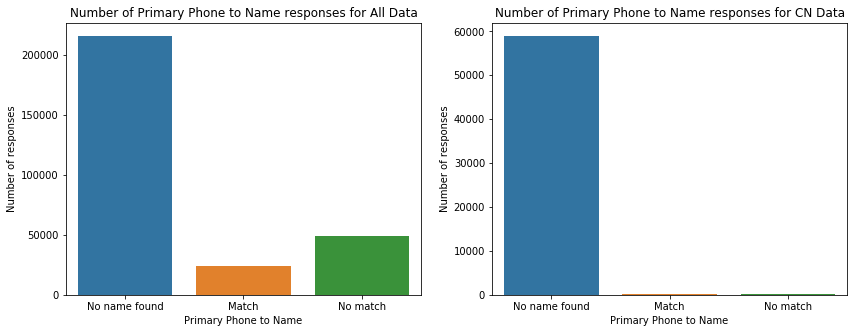

In [19]:
fraud.plot_categorical(data, data[data['input country code'] == 'cn'] , 'cn', 'Primary Phone to Name')

In order to quickly examine these criteria, I created a function to summarize analyses and create data visualizations related to these criteria (full results can be seen in the EDA notebook). The following selections for each country are a result of these analyses.

## Selected Features for China

Transactions originating from China represent about 20% of the data. The fraud rate for these transactions is similar to the entire dataset, 1.23%, only about 9% higher than the total. 

1. Email to Name
     - Moderate correlation
     - Clear differentation for 'no match' category

Although email is not a consistently good identifier (almost all emails are not associated with a name), if a name is not found and it's not a match, there may be a high chance that the transaction is fraudulent. Almost 20% of fraudulent transactions had a mismatch between name and email.

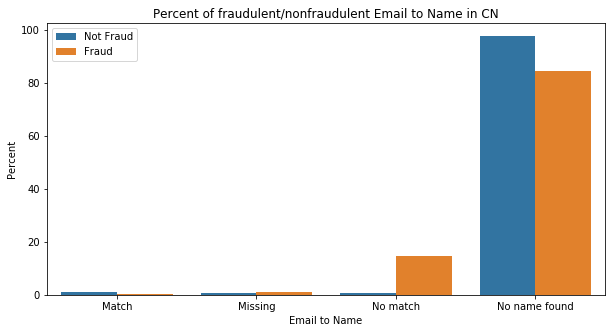

In [2]:
fraud.plot_categorical_splitdata(fraud.split_categorical(data[data['input country code'] == 'cn'], 'Email to Name'), 
                                 'Email to Name', 
                                 'cn')

2. Email First Seen Days
    - Moderate correlation
    - Interesting pattern of long-held emails and fraud

Over 75% of transactions have low first seen days values, yet about 25% of the fraudulent transactions have first seen days values over 2600 (over 7 years). Relatively few nonfraudulent transactions have values that large, so large values may lead to an increased risk of fraud.

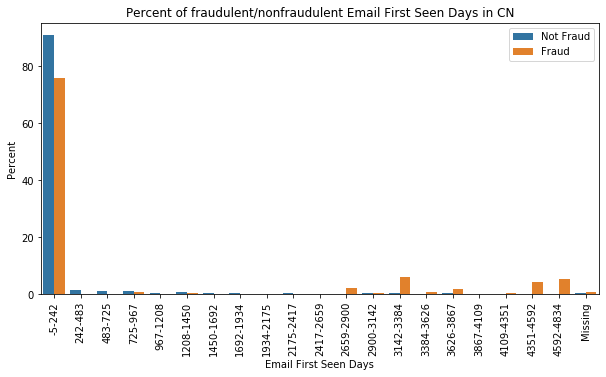

In [26]:
fraud.plot_continuous_splitdata(fraud.split_continuous(data[data['input country code'] == 'cn'], 
                                                       'Email First Seen Days', 
                                                       20), 
                                'Email First Seen Days', 
                                'cn')

3. Primary phone to name
    - Moderate correlation
    - Moderate differentiability in missing data

Phones are not a good identifier in general, but if phone data is missing, there is a higher risk of fraud. About 15% of fraudulent transactions did not return a valid response for Primary Phone to Name.

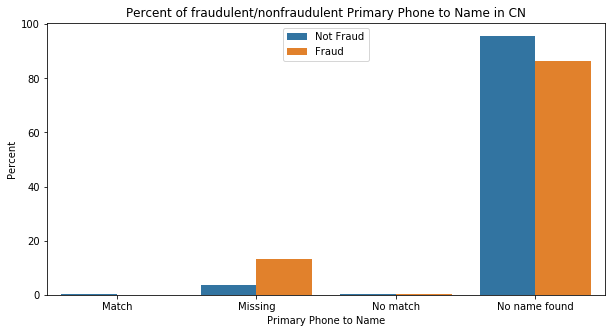

In [3]:
fraud.plot_categorical_splitdata(fraud.split_categorical(data[data['input country code'] == 'cn'], 'Primary Phone to Name'), 
                                 'Primary Phone to Name', 
                                 'cn')

In [20]:
fraud.correlations(data[data['input country code'] == 'cn'])

Feature correlations:
Email to Name_No match                 0.153906
Email First Seen Days                  0.132070
Primary Phone to Name_nan              0.053536
Email to Name_nan                      0.005308
Transaction Risk Score                 0.004158
Primary Phone to Name_No match        -0.002441
IP Distance From Address              -0.002614
Primary Phone to Name_Match           -0.004451
Email to Name_Match                   -0.009943
Primary Phone to Name_No name found   -0.048593
Email to Name_No name found           -0.091549
dtype: float64


## Selected Features for Malaysia

Malaysia represents about 30% of the transactions in the dataset. The fraud rate is very low, only 0.18%, about 84% lower than the total fraud rate. This low rate could cause problems for machine learning models attempting to predict fraudulent transactions. The most promising features for this are as follows:

1. Email First Seen Days
    - Low correlation
    - High differentiability for specific data range

Almost 30% of the fraudulent transactions have an Email First Seen Days value between 4125 and 4368. This range could be used to identify higher risk transactions.

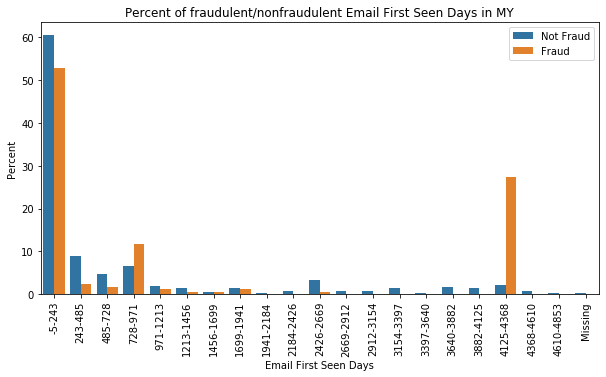

In [5]:
fraud.plot_continuous_splitdata(fraud.split_continuous(data[data['input country code'] == 'my'], 
                                                       'Email First Seen Days', 
                                                       20), 
                                'Email First Seen Days', 
                                'my')

2. Primary Phone to Name
    - Moderate correlation
    - High differentiability 

Over 60% of the fraudulent transactions had phone numbers unassociated with any name. Additionally, there is a slightly higher risk of fraud if the phone number resulted in an empty return. 

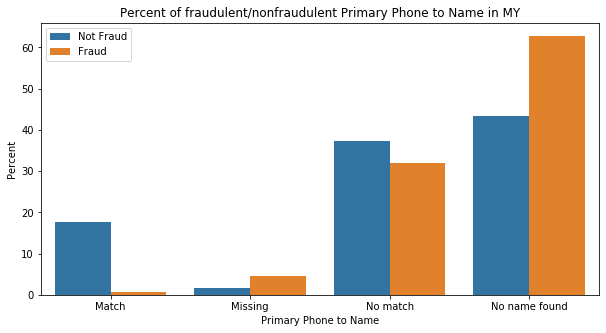

In [6]:
fraud.plot_categorical_splitdata(fraud.split_categorical(data[data['input country code'] == 'my'], 'Primary Phone to Name'), 
                                 'Primary Phone to Name', 
                                 'my')

3. Email to name
    - Moderate correlation
    - Differentiable by no match

Around 30% of the fraudulent transactions had mismatched email/name pairs.

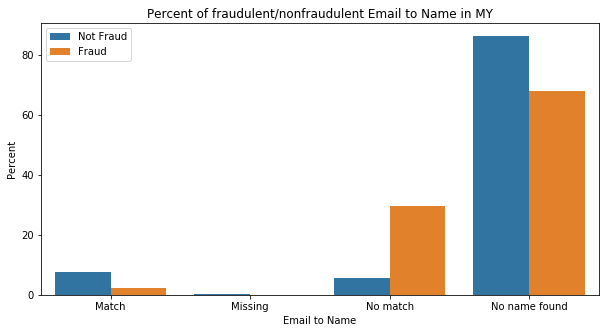

In [7]:
fraud.plot_categorical_splitdata(fraud.split_categorical(data[data['input country code'] == 'my'], 'Email to Name'), 
                                 'Email to Name', 
                                 'my')

In [4]:
fraud.correlations(data[data['input country code'] == 'my'])

Feature correlations:
Email to Name_No match                 0.043313
Email First Seen Days                  0.023721
Primary Phone to Name_No name found    0.016596
Primary Phone to Name_nan              0.010746
Transaction Risk Score                 0.007366
Email to Name_nan                     -0.002227
Primary Phone to Name_No match        -0.004738
IP Distance From Address              -0.006875
Email to Name_Match                   -0.008394
Primary Phone to Name_Match           -0.019025
Email to Name_No name found           -0.022720
dtype: float64


## Selected Features for Hong Kong

Hong Kong represents a small portion of the data, only about 0.03%. However, it has a very large fraud rate at 5.4%, 377% larger than the total fraud rate. Clearly, being able to identify fraud in this market is very important. I suggest the following features for use in building fraud detection systems for Hong Kong:

1. Primary Phone to Name
    - Strong correlation
    - Easily differentiable if phone data is missing

Over 80% of the fraudulent transactions originating in Hong Kong had missing primary phone data.  

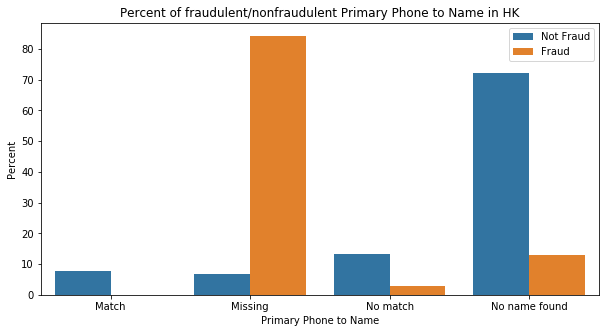

In [11]:
fraud.plot_categorical_splitdata(fraud.split_categorical(data[data['input country code'] == 'hk'], 'Primary Phone to Name'), 
                                 'Primary Phone to Name', 
                                 'hk')

2. Transaction Risk Score
    - Moderate correlation
    - Clear delimitation based on score

Over 80% of fraudulent transactions had scores over 450, clearly differentiated from the nonfraudulent data.

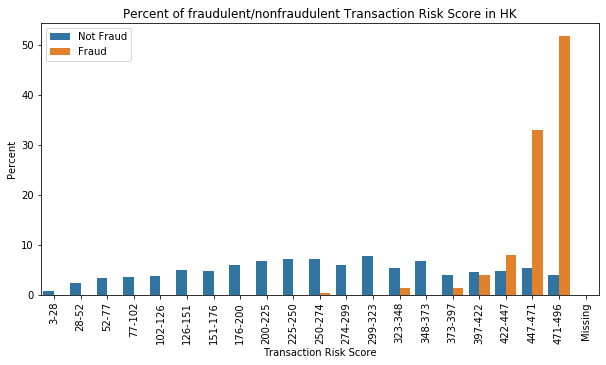

In [10]:
fraud.plot_continuous_splitdata(fraud.split_continuous(data[data['input country code'] == 'hk'], 
                                                       'Transaction Risk Score', 
                                                       20), 
                                'Transaction Risk Score', 
                                'hk')

3. IP Distance from Address
    - Moderate correlation
    - Increased distance related to higher fraud risk

About 50% of fraudulent transactions occur at distances greater than ~575.

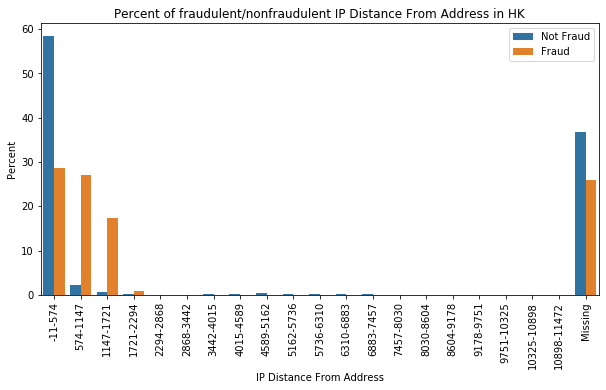

In [9]:
fraud.plot_continuous_splitdata(fraud.split_continuous(data[data['input country code'] == 'hk'], 
                                                       'IP Distance From Address', 
                                                       20), 
                                'IP Distance From Address', 
                                'hk')

In [8]:
fraud.correlations(data[data['input country code'] == 'hk'])

Feature correlations:
Primary Phone to Name_nan              0.557644
Transaction Risk Score                 0.344551
IP Distance From Address               0.142181
Email to Name_No name found            0.102393
Email to Name_nan                     -0.003318
Email to Name_No match                -0.036731
Primary Phone to Name_Match           -0.066879
Primary Phone to Name_No match        -0.070491
Email to Name_Match                   -0.093647
Email First Seen Days                 -0.145439
Primary Phone to Name_No name found   -0.289156
dtype: float64


## Future Directions

- Use different correlation techniques for comparing categorical variables, both to other categorical variables (Chi-square test of independence, Cramer's V?) and to continuous numerical variables (point-biserial correlation, one-way ANOVA?)
- Test for statistical significance in any differences between data/data distributions
- Build sample ML models (e.g., logistic regression, ensemble classifiers) to demonstrate efficacy of features
- Calculate sensitivity/recall/F1-scores for features/thresholds

## Potentially Useful Extra Data
- Transaction amount
- Credit card information (similar to previous transactions?, matches user/user location?)
- Previous fraud attempts

## Questions about Features
- How is the Transaction Risk Score calculated?
- How does missing data play into each feature?